In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import scipy
sys.path.insert(0, "/so/home/jsugiyama/git/sotodlib/")
import sotodlib
from sotodlib.tod_ops import fft_ops, detrend_tod
from sotodlib import core
from sotodlib import hwp
from sotodlib.io import load_smurf as ls
from sotodlib.io.load_smurf import Observations, Files, TuneSets, Tunes
from sotodlib.io import g3tsmurf_utils
import datetime

In [2]:
start = datetime.datetime.now()
ctx_file = '/so/metadata/satp3/contexts/use_this.yaml'
ctx = core.Context(ctx_file)
obs_id = 'obs_1709601492_satp3_1111111'
ws = 'ws0'
bandpass = 'f150'
meta = ctx.get_meta(obs_id, dets={'wafer_slot': ws, 'wafer.bandpass': bandpass})
aman = ctx.get_obs(meta)
for idet in range(aman.dets.count) : 
    aman.signal[idet] *= aman.det_cal.phase_to_pW[idet]
alive = np.where(np.any(np.isnan(aman.signal), axis=1)==False)
aman.restrict('dets', aman.dets.vals[alive])
detrend_tod(aman)
signal=aman.signal
freqs, pxx = fft_ops.calc_psd(
            aman, signal=signal, timestamps=aman.timestamps, max_samples=2**20, merge=True, nperseg=len(aman.timestamps)
        )
stop = datetime.datetime.now()
print(stop - start)

0:00:42.635184


# New features

* PSD mask
    * Masking HWPSS or vibration signals makes the fitting stable
* PSD binning
    * Fitting becomes about 25 times faster than without binning
    * Knee frequency and white noise level are unbiased
    * The standard errors of the fit parameters become smaller
* Other changes in the fitting functions
    * Fitting parameters can be reduced (white noise or alpha can be fixed)
    * Minimum frequency for the fit can be decrared
    * IndexError Exception is added to the Hessian calculation. IndexError occurs when the 1/f fit fails in the case where, for example, the signal is nan.

# "calc_psd_mask"

"calc_psd_mask" returns Ranges array to mask hwpss or single peak in the given PSD.\
If mode == "replace", it will return new mask in aman.PSD_mask.\
If mode == "add", new mask range will be added to the existing aman.PSD_mask.
You can obtain masked PSD like:\
"""\
mask = ~aman.PSD_mask.mask()\
f = f[mask]\
pxx = pxx[:, mask]\
"""

0:00:00.097778


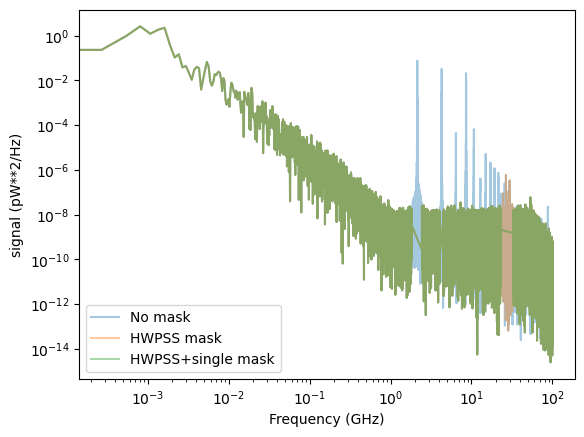

In [3]:
start = datetime.datetime.now()
plt.figure()
plt.loglog(aman.freqs, aman.Pxx[0], alpha=0.4, label="No mask")
# create hwpss mask
hwp_freq = np.median(aman['hwp_solution']['hwp_rate_1'])
fft_ops.calc_psd_mask(aman, hwpss=True, hwp_freq=hwp_freq, width_for_1f=(-0.3, +0.3), width_for_Nf=(-0.2, +0.2), mode="replace", merge=True)
mask = ~aman.PSD_mask.mask()
plt.loglog(aman.freqs[mask], aman.Pxx[0][mask], alpha=0.4, label="HWPSS mask")

# add single peak mask
fft_ops.calc_psd_mask(aman, peak=True, peak_freq=28, peak_width=(-5, +5), mode="add", merge=True)
mask = ~aman.PSD_mask.mask()
plt.loglog(aman.freqs[mask], aman.Pxx[0][mask], alpha=0.4, label="HWPSS+single mask")
plt.xlabel('Frequency (GHz)')
plt.ylabel('signal (pW**2/Hz)')
plt.legend()
stop = datetime.datetime.now()
print(stop - start)

# "fit_noise_model"

New feature of fit_noise_model is that
* Fit PSD with masks if ``mask``==True and PSD_mask in aman,
* Parameters of white noise or alpha can be fixed to the initially estimated value. For example, we experimentally know that fixing alpha is good for fitting demodulated signals.
* ``f_min`` has been added to limit the minimum frequency to fit.

In [8]:
start = datetime.datetime.now()
noise_fit_stats_fixed_wn = fft_ops.fit_noise_model(aman, 
                                          f=aman.freqs, 
                                          pxx=aman.Pxx, 
                                          lowf=1, 
                                          f_min=0.001, 
                                          f_max=20, 
                                          fwhite=(3, 20), 
                                          mask=True, 
                                          fixed_parameter="wn")
stop = datetime.datetime.now()
print(stop - start)

/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:357: RuntimeWarning: invalid value encountered in power
  return wn * (1 + (fknee / f) ** alpha)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:357: RuntimeWarning: invalid value encountered in power
  return wn * (1 + (fknee / f) ** alpha)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:357: RuntimeWarning: invalid value encountered in power
  return wn * (1 + (fknee / f) ** alpha)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:357: RuntimeWarning: invalid value encountered in power
  return wn * (1 + (fknee / f) ** alpha)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:357: RuntimeWarning: invalid value encountered in power
  return wn * (1 + (fknee / f) ** alpha)


0:02:25.631926


In [9]:
start = datetime.datetime.now()
noise_fit_stats_fixed_alpha = fft_ops.fit_noise_model(aman, 
                                          f=aman.freqs, 
                                          pxx=aman.Pxx, 
                                          lowf=1, 
                                          f_min=0.001, 
                                          f_max=20, 
                                          fwhite=(3, 20), 
                                          mask=True, 
                                          fixed_parameter="alpha")
stop = datetime.datetime.now()
print(stop - start)

/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:362: RuntimeWarning: invalid value encountered in log
  output = np.sum(np.log(model) + y / model)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:357: RuntimeWarning: invalid value encountered in power
  return wn * (1 + (fknee / f) ** alpha)


0:02:30.985355


In [18]:
start = datetime.datetime.now()
noise_fit_stats_all_params = fft_ops.fit_noise_model(aman, 
                                          f=aman.freqs, 
                                          pxx=aman.Pxx, 
                                          lowf=1, 
                                          f_min=0.001, 
                                          f_max=20, 
                                          fwhite=(3, 20), 
                                          mask=True, 
                                          fixed_parameter=None)
stop = datetime.datetime.now()
print(stop - start)

/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:357: RuntimeWarning: invalid value encountered in power
  return wn * (1 + (fknee / f) ** alpha)


0:04:38.929792


/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:357: RuntimeWarning: divide by zero encountered in divide
  return wn * (1 + (fknee / f) ** alpha)


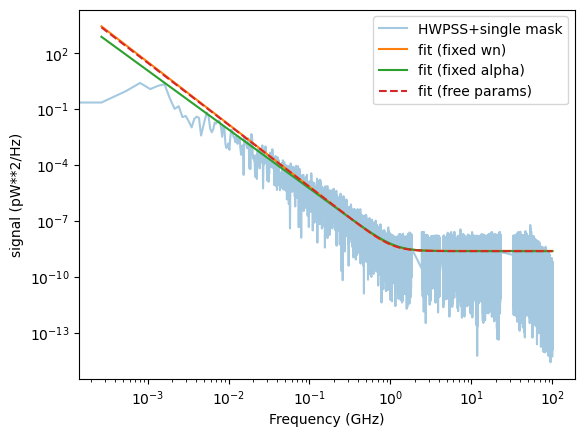

In [11]:
plt.figure()
plt.loglog(aman.freqs[mask], aman.Pxx[0][mask], alpha=0.4, label="HWPSS+single mask")

noise_fit_stats = noise_fit_stats_fixed_wn
plt.loglog(aman.freqs, fft_ops.noise_model(aman.freqs, noise_fit_stats.fit[0]), label="fit (fixed wn)")

noise_fit_stats = noise_fit_stats_fixed_alpha
plt.loglog(aman.freqs, fft_ops.noise_model(aman.freqs, noise_fit_stats.fit[0]), label="fit (fixed alpha)")

noise_fit_stats = noise_fit_stats_all_params
plt.loglog(aman.freqs, fft_ops.noise_model(aman.freqs, noise_fit_stats.fit[0]),"--",  label="fit (free params)")

plt.xlabel('Frequency (GHz)')
plt.ylabel('signal (pW**2/Hz)')
plt.legend()

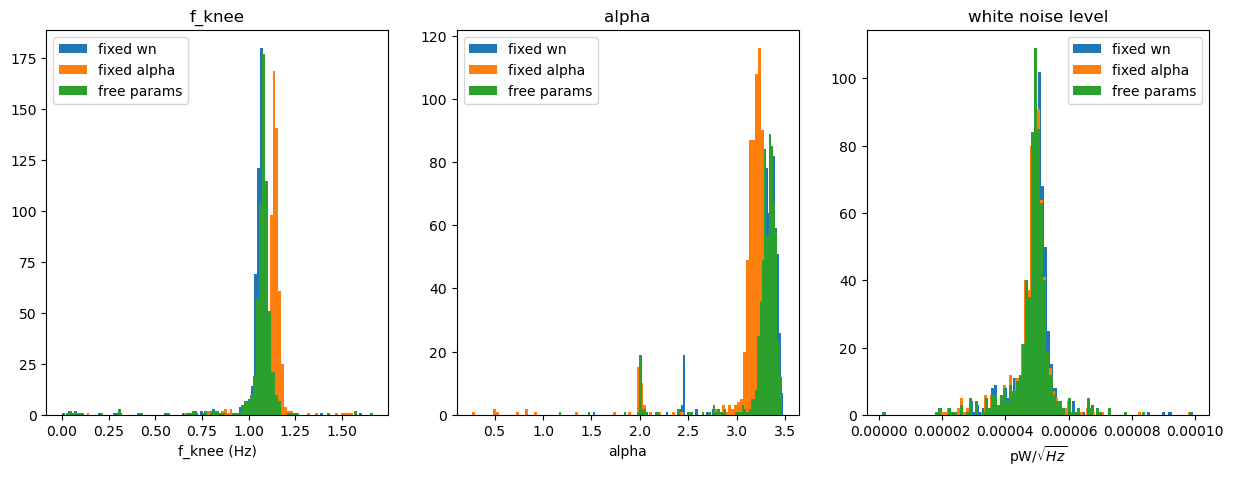

In [15]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title("f_knee")
noise_fit_stats = noise_fit_stats_fixed_wn
f_knee = noise_fit_stats.fit.T[0]
ax1.hist(f_knee[((f_knee>0)&(f_knee<2))], bins=100, label="fixed wn")

noise_fit_stats = noise_fit_stats_fixed_alpha
f_knee = noise_fit_stats.fit.T[0]
ax1.hist(f_knee[((f_knee>0)&(f_knee<2))], bins=100, label="fixed alpha")

noise_fit_stats = noise_fit_stats_all_params
f_knee = noise_fit_stats.fit.T[0]
ax1.hist(f_knee[((f_knee>0)&(f_knee<2))], bins=100, label="free params")
ax1.set_xlabel('f_knee (Hz)')
ax1.legend()

ax2 = fig.add_subplot(1, 3, 2)
ax2.set_title("alpha")
noise_fit_stats = noise_fit_stats_fixed_wn
alpha = noise_fit_stats.fit.T[2]
ax2.hist(alpha[((alpha>0)&(alpha<4))], bins=100, label="fixed wn")

noise_fit_stats = noise_fit_stats_fixed_alpha
alpha = noise_fit_stats.fit.T[2]
ax2.hist(alpha[((alpha>0)&(alpha<4))], bins=100, label="fixed alpha")

noise_fit_stats = noise_fit_stats_all_params
alpha = noise_fit_stats.fit.T[2]
ax2.hist(alpha[((alpha>0)&(alpha<4))], bins=100, label="free params")
ax2.set_xlabel('alpha')
ax2.legend()

ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title("white noise level")
noise_fit_stats = noise_fit_stats_fixed_wn
wn = noise_fit_stats.fit.T[1]
ax3.hist(np.sqrt(wn)[np.sqrt(wn)<0.0001], bins=100, label="fixed wn")

noise_fit_stats = noise_fit_stats_fixed_alpha
wn = noise_fit_stats.fit.T[1]
ax3.hist(np.sqrt(wn)[np.sqrt(wn)<0.0001], bins=100, label="fixed alpha")

noise_fit_stats = noise_fit_stats_all_params
wn = noise_fit_stats.fit.T[1]
ax3.hist(np.sqrt(wn)[np.sqrt(wn)<0.0001], bins=100, label="free params")
ax3.set_xlabel('pW/$\sqrt{Hz}$')
ax3.legend()

# "calc_binned_psd"

``calc_binned_psd`` returns the binned PSD. This function is incorporated to ``fit_binned_noise_model``.\
The parameters ``unbinned_mode`` and ``base`` changes the number of first un-binned modes and binning width, respectively.\
If the number of data points in a bin is less than ``limit_N``, that bin is handled with
chi2 distribution and its error is \<psd>. Otherwise the central limit theorem
is applied to the bin and the error is estimated as  std(psd)/sqrt(len(psd)).

In [15]:
start = datetime.datetime.now()
f_binned, pxx_binned, pxx_std = fft_ops.calc_binned_psd(aman, f=aman.freqs, pxx=aman.Pxx, unbinned_mode=3, base=1.2, limit_N=5, merge=False, mask=True)
stop = datetime.datetime.now()
print(stop - start)

0:00:05.223285


(0.0001, 50)

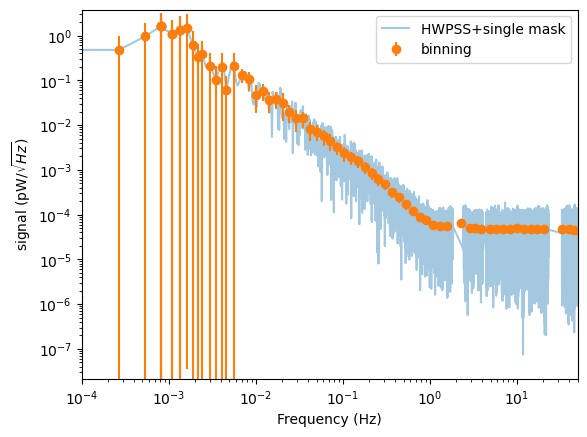

In [16]:
plt.loglog(aman.freqs[mask], np.sqrt(aman.Pxx[0][mask]), alpha=0.4, label="HWPSS+single mask")
plt.errorbar(f_binned, np.sqrt(pxx_binned[0]), yerr=np.sqrt(pxx_std[0]), fmt="o", c='tab:orange', label="binning")
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('signal (pW/$\sqrt{Hz}$)')
plt.xlim(1E-4, 50)

In [9]:
aman

AxisManager(timestamps[samps], ancil*[samps], boresight*[samps], signal[dets,samps], biases[bias_lines,samps], primary*[samps], iir_params*, flags*[dets,samps], obs_info*, det_cal*[dets], focal_plane*[dets], hwp_solution*[samps], det_info*[dets], freqs[nusamps], Pxx[dets,nusamps], PSD_mask[nusamps], dets:LabelAxis(661), samps:OffsetAxis(741367), bias_lines:LabelAxis(12), nusamps:OffsetAxis(370684))

## "fit_binned_noise_model"
This function calculates binned PSD and then starts fitting when PSD is handed.\
The calculation time cost becomes much smaller.

In [17]:
start = datetime.datetime.now()
noise_fit_stats_bin = fft_ops.fit_binned_noise_model(aman, 
                                                     f=aman.freqs, 
                                                     pxx=aman.Pxx, 
                                                     lowf=1, 
                                                     f_min=0.001, 
                                                     f_max=20, 
                                                     fwhite=(3, 20), 
                                                     mask=True, 
                                                     fixed_parameter=None,
                                                    base=1.2, limit_N=5)
stop = datetime.datetime.now()
print(stop - start)

/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:357: RuntimeWarning: invalid value encountered in power
  return wn * (1 + (fknee / f) ** alpha)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:357: RuntimeWarning: invalid value encountered in power
  return wn * (1 + (fknee / f) ** alpha)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:357: RuntimeWarning: invalid value encountered in power
  return wn * (1 + (fknee / f) ** alpha)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:357: RuntimeWarning: invalid value encountered in power
  return wn * (1 + (fknee / f) ** alpha)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:357: RuntimeWarning: invalid value encountered in power
  return wn * (1 + (fknee / f) ** alpha)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:357: RuntimeWarning: invalid value encountered in power
  return wn * (1 + (fknee / f) ** alpha)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.p

0:00:11.116900


/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:357: RuntimeWarning: invalid value encountered in power
  return wn * (1 + (fknee / f) ** alpha)


### comparison of fit results between binned and not binned PSD

(0.0001, 50)

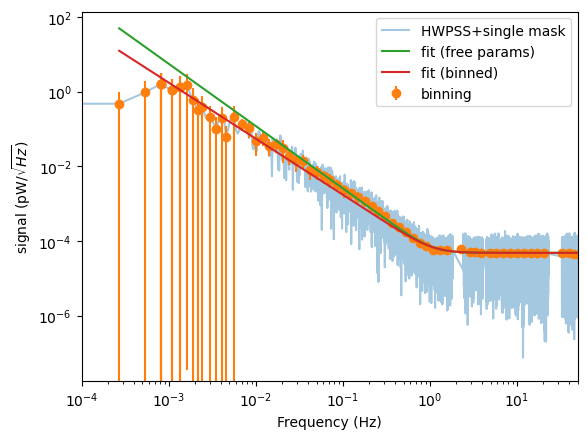

In [24]:
plt.loglog(aman.freqs[mask], np.sqrt(aman.Pxx[0][mask]), alpha=0.4, label="HWPSS+single mask", zorder=0)
plt.errorbar(f_binned, np.sqrt(pxx_binned[0]), yerr=np.sqrt(pxx_std[0]), fmt="o", label="binning", zorder=1)
noise_fit_stats = noise_fit_stats_all_params
plt.loglog(aman.freqs, np.sqrt(fft_ops.noise_model(aman.freqs, noise_fit_stats.fit[0])),  label="fit (free params)")
noise_fit_stats = noise_fit_stats_bin
plt.loglog(aman.freqs, np.sqrt(fft_ops.noise_model(aman.freqs, noise_fit_stats.fit[0])), label="fit (binned)")
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('signal (pW/$\sqrt{Hz}$)')
plt.xlim(1E-4, 50)

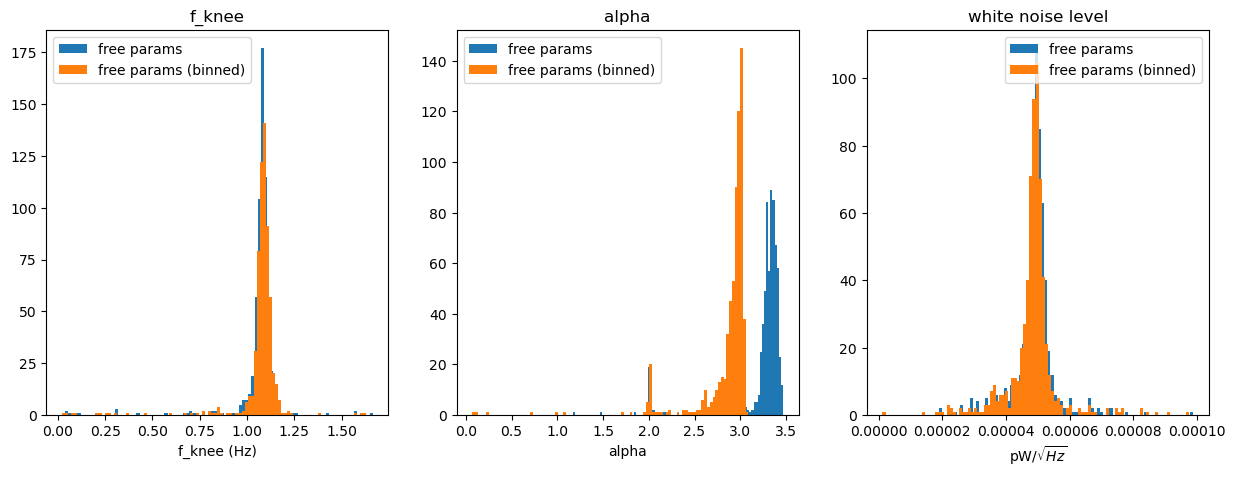

In [19]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title("f_knee")
noise_fit_stats = noise_fit_stats_all_params
f_knee = noise_fit_stats.fit.T[0]
ax1.hist(f_knee[((f_knee>0)&(f_knee<2))], bins=100, label="free params")
noise_fit_stats = noise_fit_stats_bin
f_knee = noise_fit_stats.fit.T[0]
ax1.hist(f_knee[((f_knee>0)&(f_knee<2))], bins=100, label="free params (binned)")

ax1.set_xlabel('f_knee (Hz)')
ax1.legend()

ax2 = fig.add_subplot(1, 3, 2)
ax2.set_title("alpha")
noise_fit_stats = noise_fit_stats_all_params
alpha = noise_fit_stats.fit.T[2]
ax2.hist(alpha[((alpha>0)&(alpha<4))], bins=100, label="free params")

noise_fit_stats = noise_fit_stats_bin
alpha = noise_fit_stats.fit.T[2]
ax2.hist(alpha[((alpha>0)&(alpha<4))], bins=100, label="free params (binned)")

ax2.set_xlabel('alpha')
ax2.legend()

ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title("white noise level")
noise_fit_stats = noise_fit_stats_all_params
wn = noise_fit_stats.fit.T[1]
ax3.hist(np.sqrt(wn)[np.sqrt(wn)<0.0001], bins=100, label="free params")
noise_fit_stats = noise_fit_stats_bin
wn = noise_fit_stats.fit.T[1]
ax3.hist(np.sqrt(wn)[np.sqrt(wn)<0.0001], bins=100, label="free params (binned)")
ax3.set_xlabel('pW/$\sqrt{Hz}$')
ax3.legend()

### comparison of fit parameters std errors between binned and not binned

/tmp/ipykernel_806551/1416332410.py:15: RuntimeWarning: invalid value encountered in sqrt
  f_knee.append(np.sqrt(noise_fit_stats.cov[i][0][0]))
/tmp/ipykernel_806551/1416332410.py:33: RuntimeWarning: invalid value encountered in sqrt
  alpha.append(np.sqrt(noise_fit_stats.cov[i][2][2]))
/tmp/ipykernel_806551/1416332410.py:50: RuntimeWarning: invalid value encountered in sqrt
  wn.append(np.sqrt(noise_fit_stats.cov[i][1][1]))


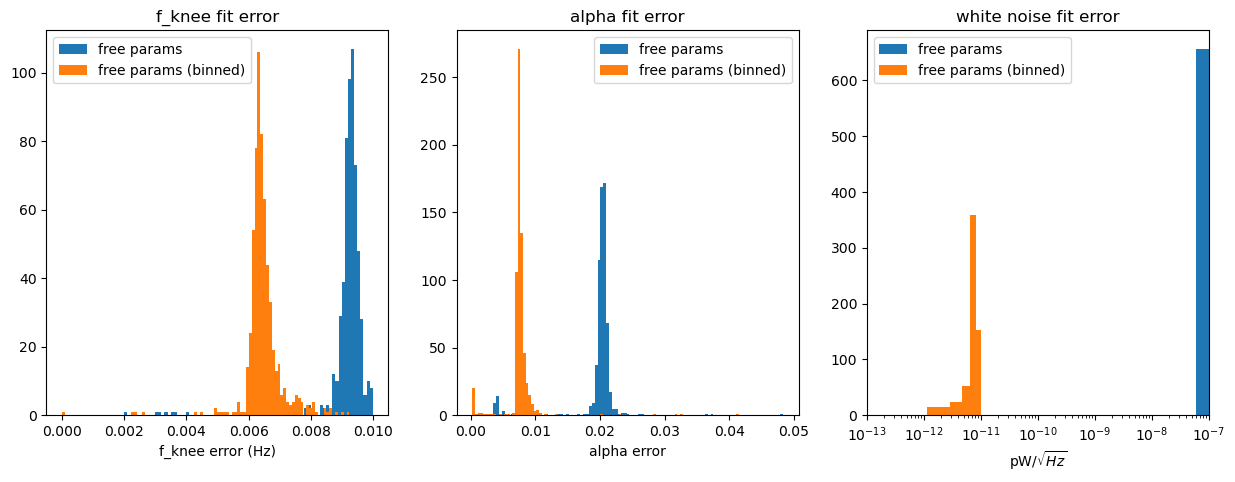

In [86]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title("f_knee fit error")
f_knee = []
alpha = []
wn = []
noise_fit_stats = noise_fit_stats_all_params
for i in range(aman.dets.count):
    f_knee.append(np.sqrt(noise_fit_stats.cov[i][0][0]))
f_knee=np.array(f_knee)
ax1.hist(f_knee[((f_knee>0)&(f_knee<0.01))], bins=100, label="free params")
noise_fit_stats = noise_fit_stats_bin
f_knee = []
for i in range(aman.dets.count):
    f_knee.append(np.sqrt(noise_fit_stats.cov[i][0][0]))
f_knee=np.array(f_knee)
ax1.hist(f_knee[((f_knee>0)&(f_knee<0.01))], bins=100, label="free params (binned)")

ax1.set_xlabel('f_knee error (Hz)')
ax1.legend()

ax2 = fig.add_subplot(1, 3, 2)
ax2.set_title("alpha fit error")
noise_fit_stats = noise_fit_stats_all_params
for i in range(aman.dets.count):
    alpha.append(np.sqrt(noise_fit_stats.cov[i][2][2]))
alpha=np.array(alpha)
ax2.hist(alpha[((alpha>0)&(alpha<0.05))], bins=100, label="free params")

noise_fit_stats = noise_fit_stats_bin
alpha = []
for i in range(aman.dets.count):
    alpha.append(np.sqrt(noise_fit_stats.cov[i][2][2]))
alpha=np.array(alpha)
ax2.hist(alpha[((alpha>0)&(alpha<0.05))], bins=100, label="free params (binned)")

ax2.set_xlabel('alpha error')
ax2.legend()

ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title("white noise fit error")
noise_fit_stats = noise_fit_stats_all_params
for i in range(aman.dets.count):
    wn.append(np.sqrt(noise_fit_stats.cov[i][1][1]))
wn=np.array(wn)
ax3.hist(wn[((1E-8<wn)&(wn<1E-7))], bins=100, label="free params")
wn = []
noise_fit_stats = noise_fit_stats_bin
for i in range(aman.dets.count):
    wn.append(np.sqrt(noise_fit_stats.cov[i][1][1]))
wn=np.array(wn)
ax3.hist(wn[((1E-13<wn)&(wn<1E-11))], bins=5, label="free params (binned)")
ax3.set_xlim(1E-13,1E-7)
ax3.set_xscale('log')
ax3.set_xlabel('pW/$\sqrt{Hz}$')
ax3.legend()